# Analisa Data Jumlah Penduduk Miskin dan Tingkat Buta Huruf di Indonesia

### Deskripsi Data
---

Data yang digunakan dalam penelitian berikut adalah data <a href="https://data.go.id/dataset/penduduk-miskin-dan-indeks-kemiskinan">"Penduduk Miskin dan Indeks Kemiskinan"</a> yang disediakan oleh Kementerian Perencanaan Pembangunan Nasional dan <a href="https://data.go.id/dataset/persentase-penduduk-buta-huruf">"Persentase Penduduk Buta Huruf"</a> yang disediakan oleh Badan Pusat Statistik. Dataset tersebut diambil melalui laman <a href="data.go.id">data.go.id</a>. 

<b>Dataset "Penduduk Miskin dan Indeks Kemiskinan"</b><br>
Dataset "Penduduk Miskin dan Indeks Kemiskinan" berisi mengenai jumlah dan persentase penduduk miskin per kabupaten/kota beserta indeks kemiskinan dan perhitungan garis kemiskinan.<br>
Penjelasan mengenai Variabel pada Dataset ini sebagai berikut:

    kode_provinsi: Kode Provinsi
    nama_provinsi: Nama Provinsi
    kode_kabkota: Kode Kabupaten/Kota
    nama_kabkota: Nama Kabupaten Kota
    tahun: Tahun
    jumlah_penduduk_miskin: Jumlah Penduduk Miskin
    persen_penduduk_miskin: Persen Penduduk Miskin
    indeks_p1: Indeks P1 (Kedalaman Kemiskinan)
    indeks_p2: Indeks P2 (Keparahan Kemiskinan)
    garis_kemiskinan: Garis Kemiskinan (Rupiah/Kapita/bulan)
<b>Dataset "Penduduk Miskin dan Indeks Kemiskinan"</b><br>
Dataset ini berisi persentase penduduk buta huruf menurut kelompok umur per propinsi dan kelompok umur.<br>
Penjelasan mengenai Variabel pada Dataset ini sebagai berikut:

    kode_provinsi: Kode Provinsi
    nama_provinsi: Nama Provinsi
    kelompok_usia: Kelompok Usia (terdiri atas: 15-, 15-44, dan 45+)
    tahun: Tahun
    persentase_buta_huruf: Persentae dari Jumlah Penduduk yang Buta Huruf pada Kelompok Usia Tersebut
Catatan:<br>
Adanya kenaikan angka buta huruf perbandingan tahun 2010 dan 2011 disebabkan:
<ul><li>Perbedaan metodologi penghitungan estimasi. Pada tahun 2010, penghitungan inflate tidak didasarkan pada kelompok umur 5 tahunan (0-4, 5-9, 10-14,..) sedangkan pada tahun 2011, penghitungan inflatenya berdasarkan kelompok umur 5 tahunan.</li>
<li>Pengumpulan data pada tahun 2010 dilakukan 1 (satu) kali dalam setahun yaitu pada bulan Juli, sedangkan pada tahun 2011 dilakukan triwulanan. Hal ini mempengaruhi penghitungan indikator pendidikan karena tahun ajaran sekolah yang dimulai pada bulan Juli berakhir pada bulan Juni tahun berikutnya.</li>
</ul>

Analisis yang akan dilakukan dalam laporan ini antara lain :
1. Runtun Waktu Buta Huruf dan Kemiskinan di Indonesia
2. Sebaran seluruh Indonesia, data mean buta huruf per provinsi utk melihat provinsi paling terdampak
3. Runtun Waktu Buta Huruf dan Kemiskinan per Provinsi di Indonesia
4. Daerah Paling Terdampak Buta Huruf dan Kemiskinan pada Tahun Terbaru di Data
5. Analisis Regresi Linear Sederhana Data Tingkat Buta Huruf dan Kemiskinan

## 1. Input dan Inisiasi Data
---
##### Import Package dan Datasets

In [1]:
from collections import Counter
from math import pi
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats as sts
import scipy.stats as stats
from itertools import groupby
import pandas as pd

from sklearn.preprocessing import Imputer

# Tools untuk melakukan visualisasi pada data
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.transform import cumsum
from bokeh.models import LinearColorMapper, BasicTicker, PrintfTickFormatter, ColorBar, ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import transform, dodge, factor_cmap
from bokeh.core.properties import value
from bokeh.palettes import Spectral5
output_notebook()

Loading BokehJS ...

In [2]:
# Import data tingkat buta huruf
databh = pd.read_csv('processeddatabutahuruf20032012perpropinsi.csv', delimiter = ',', encoding = "ISO-8859-1")
# Import data tingkat kemiskinan
datamiskin = pd.read_csv('processed-penduduk-miskin-indeks-kemiskinan-2007-2010.csv', delimiter = ',', encoding = "ISO-8859-1")

##### Menampilkan informasi dataset

In [3]:
#Mencetak informasi dari data tingkat buta huruf dan menunjukkan sampel
print(databh.info())
print("Sampel data dari persentase buta huruf :")
databh.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 5 columns):
kode_provinsi            990 non-null int64
nama_provinsi            990 non-null object
kelompok_usia            990 non-null object
tahun                    990 non-null int64
persentase_buta_huruf    963 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 38.8+ KB
None
Sampel data dari persentase buta huruf :


,kode_provinsi,nama_provinsi,kelompok_usia,tahun,persentase_buta_huruf
54,12,Prov. Sumatera Utara,45+,2007,7.41
13,11,Prov. Nanggroe Aceh Darussalam,15-44,2006,2.44
465,36,Prov. Banten,15-44,2008,1.02
808,74,Prov. Sulawesi Tenggara,45+,2011,24.43
949,91,Prov. Papua Barat,15-44,2012,3.75


Dapat dilihat terdapat kesalahan typo dalam kelompok usia, dimana semestinya (dalam hemat saya) 15+ adalah 15- karena 15+ terdefinisi sebagai usia 15 ke atas yang sudah tergolongkan dalam kelompok usia yang lain. Dengan demikian, dilakukan penggantian karakter dalam string yang ada dalam kolom <b>'kelompok_usia'</b>.

In [4]:
databh['kelompok_usia'] = databh['kelompok_usia'].replace('15+','15-')
databh.sample(5)

,kode_provinsi,nama_provinsi,kelompok_usia,tahun,persentase_buta_huruf
128,15,Prov. Jambi,15-,2011,4.48
113,14,Prov. Riau,45+,2006,7.85
312,31,Prov. DKI Jakarta,15-44,2005,0.65
741,72,Prov. Sulawesi Tengah,45+,2004,14.74
617,62,Prov. Kalimantan Tengah,15-44,2010,0.45


Diperoleh data yang sudah tepat. Selanjutnya, untuk data kemiskinan diperoleh

In [5]:
#Mencetak informasi dari data tingkat kemiskinan dan menunjukkan sampel
print(datamiskin.info())
print("\nSampel data dari data kemiskinan :")
datamiskin.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880 entries, 0 to 1879
Data columns (total 10 columns):
kode_provinsi             1880 non-null int64
nama_provinsi             1880 non-null object
kode_kabkota              1880 non-null int64
nama_kabkota              1880 non-null object
tahun                     1880 non-null int64
jumlah_penduduk_miskin    1878 non-null float64
persen_penduduk_miskin    1878 non-null float64
indeks_p1                 1878 non-null float64
indeks_p2                 1878 non-null float64
garis_kemiskinan          1878 non-null float64
dtypes: float64(5), int64(3), object(2)
memory usage: 147.0+ KB
None

Sampel data dari data kemiskinan :


,kode_provinsi,nama_provinsi,kode_kabkota,nama_kabkota,tahun,jumlah_penduduk_miskin,persen_penduduk_miskin,indeks_p1,indeks_p2,garis_kemiskinan
108,12,Prov. Sumatera Utara,1204,Kab. Tapanuli Tengah,2010,52200.0,16.73,2.86,0.75,240457.0
863,35,Prov. Jawa Timur,3503,Kab. Trenggalek,2010,108000.0,16.00,2.54,0.59,195444.0
399,16,Prov. Sumatera Selatan,1608,Kab. Ogan Komering Ulu Selatan,2010,36700.0,11.53,2.11,0.65,199259.0
1631,74,Prov. Sulawesi Tenggara,7472,Kota Baubau,2007,22600.0,17.08,2.94,0.75,167668.0
1,11,Prov. Nanggroe Aceh Darussalam,1101,Kab. Simeulue,2008,20600.0,26.45,4.51,1.19,253123.0


---
## 2. Pengolahan Data

### 2.1 Runtun Waktu Buta Huruf dan Kemiskinan di Indonesia

#### A. Tingkat Buta Huruf di Indonesia (2003 - 2012)

In [6]:
#data persentase buta huruf dikelompokkan per tahun
ax1a = databh.groupby(['tahun']).mean().drop(['kode_provinsi'], axis=1)
ax1a

,persentase_buta_huruf
tahun,
2003,11.205000
2004,10.704000
2005,10.274222
2006,10.364747
2007,9.492222
2008,9.187374
2009,8.737172
2010,8.397677
2011,8.771111


In [7]:
# Menunjukkan informasi statistik dataframe yang diperoleh
ax1a.describe()

,persentase_buta_huruf
count,10.000000
mean,9.529787
std,1.049076
min,8.164343
25%,8.745657
50%,9.339798
75%,10.342116
max,11.205000


##### Visualisasi :

In [8]:
p = figure(x_range=list(ax1a.reset_index()['tahun'].astype(str)), plot_height=350, title="Runtun Waktu Tingkat Kebutaan Huruf di Indonesia", toolbar_location=None, tools="")

p.line(x=list(ax1a.reset_index()['tahun'].astype(str)), y=ax1a['persentase_buta_huruf'], color="red", line_width=2)

p.xgrid.grid_line_color = None

show(p)

In [9]:
# generate some synthetic time series for six different categories
tahun = list(ax1a.reset_index()['tahun'].astype(str))

# find the quartiles and IQR for each category
groups = databh.drop(['kode_provinsi'], axis=1).groupby(['tahun'])
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# find the outliers for each category
def outliers(group):
    cat = group.name
    return group[(group['persentase_buta_huruf'] > upper.loc[cat]['persentase_buta_huruf']) | (group['persentase_buta_huruf'] < lower.loc[cat]['persentase_buta_huruf'])]['persentase_buta_huruf']
out = groups.apply(outliers).dropna()

# prepare outlier data for plotting, we need coordinates for every outlier.
if not out.empty:
    outx = []
    outy = []
    for keys in out.index:
        outx.append(keys[0])
        outy.append(out.loc[keys[0]].loc[keys[1]])

p = figure(tools="", background_fill_color="#efefef", x_range=tahun, toolbar_location=None)

# if no outliers, shrink lengths of stems to be no longer than the minimums or maximums
qmin = groups.quantile(q=0.00)
qmax = groups.quantile(q=1.00)
upper['persentase_buta_huruf'] = [min([x,y]) for (x,y) in zip(list(qmax.loc[:,'persentase_buta_huruf']),upper['persentase_buta_huruf'])]
lower['persentase_buta_huruf'] = [max([x,y]) for (x,y) in zip(list(qmin.loc[:,'persentase_buta_huruf']),lower['persentase_buta_huruf'])]

# garis
p.segment(tahun, upper['persentase_buta_huruf'], tahun, q3['persentase_buta_huruf'], line_color="black")
p.segment(tahun, lower['persentase_buta_huruf'], tahun, q1['persentase_buta_huruf'], line_color="black")

# kotak
p.vbar(tahun, 0.7, q2['persentase_buta_huruf'], q3['persentase_buta_huruf'], fill_color="red", line_color="black")
p.vbar(tahun, 0.7, q1['persentase_buta_huruf'], q2['persentase_buta_huruf'], fill_color="white", line_color="black")

# batas atas dan batas bawah
p.rect(tahun, lower['persentase_buta_huruf'], 0.2, 0.01, line_color="black")
p.rect(tahun, upper['persentase_buta_huruf'], 0.2, 0.01, line_color="black")

# pencilan
if not out.empty:
    p.circle(outx, outy, size=6, color="#F38630", fill_alpha=0.6)

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="12pt"

show(p)

##### Analisis :
---

Dalam kurun waktu 2003 - 2012, Indonesia dominan mengalami penurunan tingkat kebutaan huruf secara nasional. Dalam hal ini merupakan kemajuan yang positif bagi Indonesia. Kenaikan tingkat buta huruf terjadi di tahun 2006 meski dalam taraf yang tidak cukup signifikan. Tahun berikutnya, penurunan terus terjadi hingga di tahun 2011, tingkat kebutaan huruf naik karena faktor yang telah penulis jelaskan sebelumnya yang penulis kutip dari sumber data, bahwa ada perbedaan metode penelitian yang membuat perbedaan tersebut.

Dari boxplot juga dapat ditinjau bahwa per tahun data yang tersaji cenderung miring ke kanan, dan tidak diketahui adanya pencilan. Maksimum dari tingkat kebutaan huruf juga dapat dilihat dari batas garis atas boxplot, yang jalannya per tahun cenderung naik turun. Sementara nilai minimumnya cenderung stabil.

#### B. Tingkat Kemiskinan di Indonesia (2007 - 2010)

In [10]:
#data persentase buta huruf dikelompokkan per tahun
ax1b = datamiskin[['persen_penduduk_miskin', 'tahun']].groupby(['tahun']).mean()
ax1b

,persen_penduduk_miskin
tahun,
2007,18.563722
2008,16.880219
2009,16.249575
2010,15.496881


In [11]:
#Menunjukkan informasi statistik dataframe yang diperoleh
ax1b.describe()

,persen_penduduk_miskin
count,4.000000
mean,16.797600
std,1.306167
min,15.496881
25%,16.061402
50%,16.564897
75%,17.301095
max,18.563722


##### Visualisasi :

In [12]:
p = figure(x_range=list(ax1b.reset_index()['tahun'].astype(str)), plot_height=350, title="Runtun Waktu Tingkat Kemiskinan di Indonesia",
           toolbar_location=None, tools="")

p.line(x=list(ax1b.reset_index()['tahun'].astype(str)), y=ax1b['persen_penduduk_miskin'], color="red", line_width=2)

p.xgrid.grid_line_color = None

show(p)

In [13]:
# generate some synthetic time series for six different categories
tahun = list(ax1b.reset_index()['tahun'].astype(str))

# find the quartiles and IQR for each category
groups = datamiskin[['persen_penduduk_miskin', 'tahun']].groupby(['tahun'])
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# find the outliers for each category
def outliers(group):
    cat = group.name
    return group[(group['persen_penduduk_miskin'] > upper.loc[cat]['persen_penduduk_miskin']) | (group['persen_penduduk_miskin'] < lower.loc[cat]['persen_penduduk_miskin'])]['persen_penduduk_miskin']
out = groups.apply(outliers).dropna()

# prepare outlier data for plotting, we need coordinates for every outlier.
if not out.empty:
    outx = []
    outy = []
    for keys in out.index:
        outx.append(keys[0])
        outy.append(out.loc[keys[0]].loc[keys[1]])

p = figure(tools="", background_fill_color="#efefef", x_range=tahun, toolbar_location=None)

# if no outliers, shrink lengths of stems to be no longer than the minimums or maximums
qmin = groups.quantile(q=0.00)
qmax = groups.quantile(q=1.00)
upper['persen_penduduk_miskin'] = [min([x,y]) for (x,y) in zip(list(qmax.loc[:,'persen_penduduk_miskin']),upper['persen_penduduk_miskin'])]
lower['persen_penduduk_miskin'] = [max([x,y]) for (x,y) in zip(list(qmin.loc[:,'persen_penduduk_miskin']),lower['persen_penduduk_miskin'])]

# garis
p.segment(tahun, upper['persen_penduduk_miskin'], tahun, q3['persen_penduduk_miskin'], line_color="black")
p.segment(tahun, lower['persen_penduduk_miskin'], tahun, q1['persen_penduduk_miskin'], line_color="black")

# kotak
p.vbar(tahun, 0.7, q2['persen_penduduk_miskin'], q3['persen_penduduk_miskin'], fill_color="red", line_color="black")
p.vbar(tahun, 0.7, q1['persen_penduduk_miskin'], q2['persen_penduduk_miskin'], fill_color="white", line_color="black")

# batas atas dan batas bawah
p.rect(tahun, lower['persen_penduduk_miskin'], 0.2, 0.01, line_color="black")
p.rect(tahun, upper['persen_penduduk_miskin'], 0.2, 0.01, line_color="black")

# pencilan
if not out.empty:
    p.circle(outx, outy, size=6, color="#F38630", fill_alpha=0.6)

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="12pt"

show(p)

##### Analisis :
---

Dalam kurun waktu 2007 - 2010, Indonesia mengalami penurunan tingkat kemiskinan secara nasional. Dalam hal ini merupakan kemajuan yang positif bagi Indonesia. Penurunan cukup signifikan terjadi di tahun 2008, dan penurunan di tahun-tahun selanjutnya cenderung dalam <i>slope</i> yang konstan.

Dari boxplot juga dapat ditinjau bahwa per tahun data yang tersaji cenderung simetris (berdistribusi normal), meski di tahun tertentu seperti 2008 dan 2009 cenderung miring ke kanan. Dari grafik boxplot tersebut juga tidak diketahui adanya pencilan data. Maksimum dari tingkat kemiskinan juga dapat dilihat dari batas garis atas boxplot, yang jalannya per tahun cenderung turun. Sementara nilai minimumnya cenderung stabil.

### 2.2 Sebaran seluruh Indonesia, data mean huruf dan kemiskinan utk melihat provinsi paling terdampak

#### A. Tingkat Buta Huruf di Indonesia per provinsi

In [14]:
#data persentase buta huruf dikelompokkan per kelompok usia berdasar rata-rata dalam kurun waktu 2003-2012 per provinsi
ax2a = databh.groupby(['nama_provinsi','kelompok_usia']).mean().drop(['kode_provinsi','tahun'], axis=1)
ax2a

persentase_buta_huruf
nama_provinsi           kelompok_usia                       
Prov. Bali              15-                        13.015000
                        15-44                       3.631000
                        45+                        30.785000
Prov. Banten            15-                         4.624000
                        15-44                       1.467000
                        45+                        14.541000
Prov. Bengkulu          15-                         5.551000
                        15-44                       1.730000
                        45+                        15.994000
Prov. D I Yogyakarta    15-                        11.356000
                        15-44                       1.355000
                        45+                        27.064000
Prov. DKI Jakarta       15-                         1.326000
                        15-44                       0.403000
                        45+                         4.048000
Prov. Gorontalo         15-                         4.703000
                        15-44                       2.804000
                        45+                         9.606000
Prov. Jambi             15-                         4.680000
                        15-44                       1.540000
                        45+                        13.338000
Prov. Jawa Barat        15-                         4.750000
                        15-44                       1.225000
                        45+                        12.794000
Prov. Jawa Tengah       15-                        11.378000
                        15-44                       2.354000
                        45+                        26.942000
Prov. Jawa Timur        15-                        13.048000
                        15-44                       3.558000
                        45+                        29.316000
...                                                      ...
Prov. Papua Barat       15-                         7.681429
                        15-44                       5.537143
                        45+                        14.981429
Prov. Riau              15-                         2.559000
                        15-44                       0.975000
                        45+                         7.859000
Prov. Sulawesi Barat    15-                        12.560000
                        15-44                       6.381429
                        45+                        28.912857
Prov. Sulawesi Selatan  15-                        13.747000
                        15-44                       5.694000
                        45+                        31.533000
Prov. Sulawesi Tengah   15-                         5.136000
                        15-44                       2.439000
                        45+                        12.590000
Prov. Sulawesi Tenggara 15-                         9.118000
                        15-44                       3.153000
                        45+                        26.156000
Prov. Sulawesi Utara    15-                         0.972000
                        15-44                       0.520000
                        45+                         1.835000
Prov. Sumatera Barat    15-                         3.728000
                        15-44                       1.230000
                        45+                         8.627000
Prov. Sumatera Selatan  15-                         3.507000
                        15-44                       1.161000
                        45+                         9.613000
Prov. Sumatera Utara    15-                         3.114000
                        15-44                       1.186000
                        45+                         7.855000

[99 rows x 1 columns]

##### Visualisasi :

In [15]:
#pendefinisian fungsi untuk plotting pie chart dari data tingkat buta huruf per provinsi yang digolongkan per kelompok usia sebagai variabel fungsi

def gambarusia(x):
    ax2aa = databh.loc[databh['kelompok_usia'] == x, ['nama_provinsi','persentase_buta_huruf']].groupby(['nama_provinsi']).mean()

    #mendefinisikan sudut dan warna ke per bagian dalam pie chart
    ax2aa['angle'] = ax2aa['persentase_buta_huruf']/ax2aa['persentase_buta_huruf'].sum() * 2*pi
    ax2aa['color'] = ['#E50000','#E22200','#DF4400','#DD6500','#DA8600','#D8A500','#D5C400','#C3D200','#A1D000','#80CD00','#5FCB00','#3FC800','#20C501','#02C301','#01C01C','#01BE39','#01BB55','#01B870','#01B68A','#01B3A3','#01A5B1','#0188AE','#016CAB','#0151A9','#0137A6','#011DA4','#0104A1','#17019E','#2E019C','#450199','#5A0197','#6F0194','#830291']

    #mendefinisikan fungsi gambar
    p = figure(plot_height=850, plot_width=950, toolbar_location=None, tools="hover", tooltips="@nama_provinsi: @persentase_buta_huruf")

    p.title.text = "Sebaran Data Persentase Buta Huruf pada Kelompok Usia "+x
    p.title.align = "center"
    p.title.text_font_size = "20px"

    p.wedge(x=0, y=1, radius=0.5,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="white", fill_color='color', legend='nama_provinsi', source=ax2aa)

    p.axis.axis_label=None
    p.axis.visible=False
    p.legend.label_text_font_size='8pt'
    p.grid.grid_line_color = None
    
    show(p)

In [16]:
# Plotting pie chart untuk kelompok usia 15-
gambarusia('15-')

##### Analisis :
---
Diperoleh dalam kurun waktu dari tahun 2003 hingga 2012, tingkat buta huruf untuk kelompok usia 15 tahun ke bawah di Provinsi Papua masih menempati peringkat tertinggi dari seluruh provinsi di Indonesia dengan prosentase sebesar $29.487\%$. Dalam urutan kedua dan ketiga ditempati oleh NTB dan Sulawesi Selatan.

Sementara itu, untuk provinsi yang menempati peringkat terendah untuk tingkat buta huruf kelompok usia 15 tahun ke bawah adalah provinsi Sulawesi Utara yang hanya $0.972\%$, disusul oleh DKI Jakarta dan Riau.

In [17]:
# Plotting pie chart untuk kelompok usia 15-44
gambarusia('15-44')

##### Analisis :
---
Diperoleh dalam kurun waktu dari tahun 2003 hingga 2012, tingkat buta huruf untuk kelompok usia produktif (15 - 44 tahun) di Provinsi Papua masih sama (menempati peringkat tertinggi) dari seluruh provinsi di Indonesia dengan prosentase sebesar $27.859\%$ yang walaupun lebih kecil dibanding prosentase usia 15-, namun lebih dominan dibanding urutan kedua dan ketiga yang ditempati oleh NTB dan Sulawesi Barat.

Sementara itu, untuk provinsi yang menempati peringkat terendah untuk tingkat buta huruf kelompok usia 15-44 tahun adalah provinsi DKI Jakarta yang hanya $0.403\%$, disusul oleh Sulawesi Utara dan Riau.

In [18]:
# Plotting pie chart untuk kelompok usia 45+
gambarusia('45+')

##### Analisis :
---
Diperoleh dalam kurun waktu dari tahun 2003 hingga 2012, tingkat buta huruf untuk kelompok usia senja (45+ tahun) ternyata tidak lagi didominasi dari provinsi Papua, melainkan NTB yang prosentasenya sebesar $46.526\%$, disusul urutan kedua dan ketiga yang ditempati oleh Papua dan Sulawesi Selatan.

Sementara itu, untuk provinsi yang menempati peringkat terendah untuk tingkat buta huruf kelompok usia 45 tahun ke atas adalah provinsi Sulawesi Utara yang hanya $1.835\%$, disusul oleh DKI Jakarta dan Maluku.

#### B. Tingkat Kemiskinan di Indonesia per Provinsi

In [19]:
#data persentase buta huruf dikelompokkan per kelompok usia berdasar rata-rata dalam kurun waktu 2003-2012 per provinsi
ax2b = datamiskin[['nama_provinsi','persen_penduduk_miskin']].groupby(['nama_provinsi']).mean()
ax2b

,persen_penduduk_miskin
nama_provinsi,
Prov. Bali,6.151944
Prov. Banten,7.867778
Prov. Bengkulu,23.488649
Prov. D I Yogyakarta,18.187500
Prov. DKI Jakarta,5.746667
Prov. Gorontalo,20.649583
Prov. Jambi,9.263415
Prov. Jawa Barat,12.368942
Prov. Jawa Tengah,17.390571


In [20]:
#visualisasi pie chart tingkat kemiskinan per provinsi

#mendefinisikan sudut dan warna ke per bagian dalam pie chart
ax2b['angle'] = ax2b['persen_penduduk_miskin']/ax2b['persen_penduduk_miskin'].sum() * 2*pi
ax2b['color'] = ['#E50000','#E22200','#DF4400','#DD6500','#DA8600','#D8A500','#D5C400','#C3D200','#A1D000','#80CD00','#5FCB00','#3FC800','#20C501','#02C301','#01C01C','#01BE39','#01BB55','#01B870','#01B68A','#01B3A3','#01A5B1','#0188AE','#016CAB','#0151A9','#0137A6','#011DA4','#0104A1','#17019E','#2E019C','#450199','#5A0197','#6F0194','#830291']

#mendefinisikan fungsi gambar
p = figure(plot_height=850, plot_width=950, toolbar_location=None, tools="hover", tooltips="@nama_provinsi: @persen_penduduk_miskin")

p.title.text = "Sebaran Data Persentase Kemisikinan"
p.title.align = "center"
p.title.text_font_size = "20px"

p.wedge(x=0, y=1, radius=0.5,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend='nama_provinsi', source=ax2b)

p.axis.axis_label=None
p.axis.visible=False
p.legend.label_text_font_size='8pt'
p.grid.grid_line_color = None

show(p)

##### Analisis :
---
Diperoleh dalam kurun waktu dari tahun 2007 hingga 2010, tingkat kemiskinan di Provinsi Papua masih menempati peringkat tertinggi dari seluruh provinsi di Indonesia dengan prosentase sebesar $37.399\%$. Dalam urutan kedua dan ketiga ditempati oleh Papua Barat dan Maluku.

Sementara itu, untuk provinsi yang menempati peringkat terendah untuk tingkat kemiskinan adalah provinsi DKI Jakarta yang hanya $5.747\%$, disusul oleh Kalimantan Selatan dan Bali.

### 2.3 Runtun Waktu Buta Huruf dan Kemiskinan per Provinsi di Indonesia

#### A. Runtun Waktu tingkat Buta Huruf di Indonesia per provinsi

In [21]:
#data persentase buta huruf dikelompokkan per kelompok usia berdasar rata-rata dalam kurun waktu 2003-2012 per provinsi
ax3a = databh.drop(['kode_provinsi'], axis=1).groupby(['nama_provinsi','tahun']).mean().reset_index()
ax3a[['tahun']]=ax3a[['tahun']].astype(str)
ax3th = list(ax3a['tahun'].unique())
ax3pr = list(ax3a['nama_provinsi'].unique())

#Pembuatan dataframe untuk menampilkan tabel matriks
ax3a_mth = { i: list(ax3a[ax3a['tahun']==i]['persentase_buta_huruf']) for i in ax3th }
ax3a_mtg = pd.DataFrame(ax3a_mth, index=ax3pr)
ax3a_mtg

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Prov. Bali,19.110000,18.110000,16.843333,17.266667,16.663333,15.650000,14.983333,14.210000,13.126667,12.140000
Prov. Banten,9.200000,9.266667,6.626667,7.240000,6.586667,6.986667,6.043333,5.826667,5.660000,5.336667
Prov. Bengkulu,8.880000,8.743333,9.196667,8.603333,8.070000,7.583333,7.026667,6.596667,6.770000,6.113333
Prov. D I Yogyakarta,17.260000,16.980000,15.553333,15.733333,14.170000,12.053333,11.100000,10.576667,9.866667,9.290000
Prov. DKI Jakarta,2.426667,2.520000,2.443333,2.536667,1.750000,1.816667,1.470000,1.276667,1.623333,1.393333
Prov. Gorontalo,6.343333,6.486667,5.850000,5.036667,4.743333,5.780000,5.353333,5.293333,6.396667,5.760000
Prov. Jambi,6.740000,6.186667,7.690000,7.100000,6.900000,6.603333,6.310000,5.823333,6.253333,5.586667
Prov. Jawa Barat,8.120000,8.196667,7.026667,6.563333,5.833333,5.740000,5.270000,5.260000,5.410000,5.143333
Prov. Jawa Tengah,17.513333,16.463333,15.313333,14.193333,13.163333,12.450000,12.186667,11.630000,11.393333,11.273333
Prov. Jawa Timur,19.846667,18.743333,16.843333,15.190000,14.380000,14.553333,13.996667,13.423333,13.426667,12.670000


Ditinjau dari tabel di atas, terdapat nilai yang tidak diketahui yang diidentifikasikan melalui <b>NaN</b> value. Untuk mengisi kekosongan data ini, dilakukan pengisian nilai mean dari masing-masing provinsi untuk mengisi kekosongan data tersebut.

In [22]:
ax3a_mtg = ax3a_mtg.T.fillna(ax3a_mtg.mean(axis=1)).T
ax3a_mtg

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Prov. Bali,19.110000,18.110000,16.843333,17.266667,16.663333,15.650000,14.983333,14.210000,13.126667,12.140000
Prov. Banten,9.200000,9.266667,6.626667,7.240000,6.586667,6.986667,6.043333,5.826667,5.660000,5.336667
Prov. Bengkulu,8.880000,8.743333,9.196667,8.603333,8.070000,7.583333,7.026667,6.596667,6.770000,6.113333
Prov. D I Yogyakarta,17.260000,16.980000,15.553333,15.733333,14.170000,12.053333,11.100000,10.576667,9.866667,9.290000
Prov. DKI Jakarta,2.426667,2.520000,2.443333,2.536667,1.750000,1.816667,1.470000,1.276667,1.623333,1.393333
Prov. Gorontalo,6.343333,6.486667,5.850000,5.036667,4.743333,5.780000,5.353333,5.293333,6.396667,5.760000
Prov. Jambi,6.740000,6.186667,7.690000,7.100000,6.900000,6.603333,6.310000,5.823333,6.253333,5.586667
Prov. Jawa Barat,8.120000,8.196667,7.026667,6.563333,5.833333,5.740000,5.270000,5.260000,5.410000,5.143333
Prov. Jawa Tengah,17.513333,16.463333,15.313333,14.193333,13.163333,12.450000,12.186667,11.630000,11.393333,11.273333
Prov. Jawa Timur,19.846667,18.743333,16.843333,15.190000,14.380000,14.553333,13.996667,13.423333,13.426667,12.670000


##### Visualisasi :

In [23]:
# mendefinsikan dataset untuk source yang telah dicleansing
newrow = []
for i in ax3pr:
    newrow.extend(ax3a_mtg[ax3a_mtg.index == i].values.tolist()[0])
ax3a['persentase_buta_huruf']=newrow

# pewarnaan dan mapping
colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
mapper = LinearColorMapper(palette=colors, low=ax3a_mtg.min().min(), high=ax3a_mtg.max().max())

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(title="Tingkat Buta Huruf per Provinsi tahun {0} - {1}".format(ax3th[0], ax3th[-1]),
           x_range=ax3th, y_range=list(reversed(ax3pr)),
           x_axis_location="above", plot_width=800, plot_height=700,
           tools=TOOLS, toolbar_location='below',
           tooltips=[('rate', '@persentase_buta_huruf%')])

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "8pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = 0

p.rect(x="tahun", y="nama_provinsi", width=1, height=1,
       source=ax3a,
       fill_color=transform('persentase_buta_huruf', mapper),
       line_color=None)


color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="7pt",
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=PrintfTickFormatter(format="%d%%"),
                     label_standoff=6, border_line_color=None, location=(0, 0))
p.add_layout(color_bar, 'right')

show(p)      # show the plot

##### Analisis :
---
Dari grafik tersebut, semakin muda dan memerah warnanya, maka tingkat persentase makin tinggi. Sebagaimana hasil yang diperoleh pada subchapter 2.2 apabila dirata-ratakan untuk semua kelompok usia, provinsi paling terdampak buta huruf (yang paling merah) adalah provinsi Papua. Untuk provinsi Papua sendiri, dari kurun waktu 2003 menuju 2006 sempat memburuk, kemudian membaik, dan berangsur memburuk kembali. Sementara itu, untuk provinsi lain, makin mendekati 2012, dominan tingkat persentase buta hurufnya menurun. Selain itu, ada beberapa daerah yang persentase buta hurufnya selalu terlihat rendah (selalu hijau tua) dalam kurung waktu 2003-2012, contohnya adalah DKI Jakarta.

Melihat grafik tersebut, sebetulnya dapat disimpulkan bahwa tingkat buta huruf yang sangat terdampak memiliki nilai yang timpang dibandingkan provinsi lainnya secara merata. Membandingkan Papua dan DKI Jakarta, terlihat sangat jelas perbedaannya.

#### B. Runtun Waktu tingkat Kemiskinan di Indonesia per provinsi

In [24]:
#data persentase buta huruf dikelompokkan per kelompok usia berdasar rata-rata dalam kurun waktu 2003-2012 per provinsi
ax3b = datamiskin[['nama_provinsi','nama_kabkota',
                    'tahun','persen_penduduk_miskin']].groupby(['nama_provinsi','tahun']).mean().reset_index()
ax3b[['tahun']]=ax3b[['tahun']].astype(str)
ax3bth = list(ax3b['tahun'].unique())
ax3bpr = list(ax3b['nama_provinsi'].unique())

# Pembuatan dataframe untuk menampilkan tabel matriks
ax3b_mth = { i: list(ax3b[ax3b['tahun']==i]['persen_penduduk_miskin']) for i in ax3bth }
ax3b_mtg = pd.DataFrame(ax3b_mth, index=ax3bpr)
ax3b_mtg

,2007,2008,2009,2010
Prov. Bali,7.110000,6.137778,5.084444,6.275556
Prov. Banten,9.391667,8.211667,7.391429,6.883750
Prov. Bengkulu,23.764444,19.658889,35.311111,16.047000
Prov. D I Yogyakarta,19.856000,18.900000,17.646000,16.348000
Prov. DKI Jakarta,6.476667,5.561667,5.343333,5.605000
Prov. Gorontalo,27.151667,20.403333,18.355000,16.688333
Prov. Jambi,10.965000,9.375000,8.622000,8.198182
Prov. Jawa Barat,12.993846,13.134231,11.978077,11.369615
Prov. Jawa Tengah,19.310571,18.116857,16.671714,15.463143
Prov. Jawa Timur,19.642632,17.925263,15.975000,14.840789


##### Visualisasi :

In [25]:
# this is the colormap from the original NYTimes plot
colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
mapper = LinearColorMapper(palette=colors, low=ax3b_mtg.min().min(), high=ax3b_mtg.max().max())

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(title="Runtun Waktu Tingkat Kemiskinan per Provinsi tahun {0} - {1}".format(ax3bth[0], ax3bth[-1]),
           x_range=ax3bth, y_range=list(reversed(ax3bpr)),
           x_axis_location="above", plot_width=800, plot_height=700,
           tools=TOOLS, toolbar_location='below',
           tooltips=[('rate', '@persen_penduduk_miskin%')])

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "8pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = 0

p.rect(x="tahun", y="nama_provinsi", width=1, height=1,
       source=ax3b,
       fill_color=transform('persen_penduduk_miskin', mapper),
       line_color=None)


color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="7pt",
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=PrintfTickFormatter(format="%d%%"),
                     label_standoff=6, border_line_color=None, location=(0, 0))
p.add_layout(color_bar, 'right')

show(p)      # show the plot

##### Analisis :
---
Dari grafik tersebut, semakin muda dan memerah warnanya, maka tingkat persentase makin tinggi. Sebagaimana hasil yang diperoleh pada subchapter 2.2, provinsi paling terdampak kemiskinan adalah provinsi Papua. Dalam kurun waktu 2007-2010, tidak ada perbaikan signifikan yang berarti dari tingkat kemiskinan di Papua, yang ditunjukkan dengan warna yang masih memerah. Meski demikian, hampir seluruh provinsi lain menunjukkan adanya penurunan tingkat kemiskinan yang ditunjukkan dengan warna yang semakin mendekati hijau tua. Dengan demikian, dapat dikatakan Indonesia mengalami perbaikan dalam mengatasi masalah kemiskinan, sebagaimana yang ditunjukkan dalam subchapter 2.1.

Selain itu, ada beberapa provinsi yang menunjukkan tingkat kemiskinan yang rendah dan stabil (selalu hijau tua), contohnya DKI Jakarta atau Bali. Lebih lanjut, melihat grafik tersebut, sebetulnya dapat disimpulkan bahwa tingkat kemiskinan yang sangat terdampak memiliki nilai yang timpang dibandingkan provinsi lainnya secara merata. Membandingkan Papua dan DKI Jakarta, terlihat sangat jelas perbedaannya.

### 2.4. Daerah Paling Terdampak Buta Huruf dan Kemiskinan pada Tahun Terbaru di Data

#### A. Daerah Paling Terdampak Buta Huruf

In [26]:
ax4agr = databh.loc[databh['tahun']==databh['tahun'].iloc[-1],['nama_provinsi','kelompok_usia','persentase_buta_huruf']]
ax4a = ax4agr.groupby(['nama_provinsi']).mean().sort_values('persentase_buta_huruf', ascending=False).head(10)
ax4a

,persentase_buta_huruf
nama_provinsi,
Prov. Papua,35.560000
Prov. Nusa Tenggara Barat,21.393333
Prov. Sulawesi Barat,14.053333
Prov. Sulawesi Selatan,14.046667
Prov. Nusa Tenggara Timur,13.453333
Prov. Jawa Timur,12.670000
Prov. Sulawesi Tenggara,12.370000
Prov. Bali,12.140000
Prov. Kalimantan Barat,12.033333


##### Visualisasi :

In [27]:
provinsi = list(ax4a.index)
years = ['15-', '15-44', '45+']

ax4a_15=ax4agr.loc[ax4agr['nama_provinsi'].isin(list(ax4a.index))].loc[ax4agr['kelompok_usia'] == '15+'].set_index('nama_provinsi').reindex(index=list(ax4a.index)).reset_index()['persentase_buta_huruf']
ax4a_prod=ax4agr.loc[ax4agr['nama_provinsi'].isin(list(ax4a.index))].loc[ax4agr['kelompok_usia'] == '15-44'].set_index('nama_provinsi').reindex(index=list(ax4a.index)).reset_index()['persentase_buta_huruf']
ax4a_45=ax4agr.loc[ax4agr['nama_provinsi'].isin(list(ax4a.index))].loc[ax4agr['kelompok_usia'] == '45+'].set_index('nama_provinsi').reindex(index=list(ax4a.index)).reset_index()['persentase_buta_huruf']

data = {'prov' : provinsi,
        '15-'   : list(ax4a_15),
        'prod'   : list(ax4a_prod),
        '45+'   : list(ax4a_45)}

source = ColumnDataSource(data=data)

p = figure(x_range=provinsi, y_range=(0, 50), plot_width=970, plot_height=350, title="Provinsi Paling Terdampak Buta Huruf pada tahun {0}".format(databh['tahun'].iloc[-1]),
           toolbar_location=None, tools="")

p.vbar(x=dodge('prov', -0.25, range=p.x_range), top='15-', width=0.2, source=source,
       color="#c9d9d3", legend=value("15-"))

p.vbar(x=dodge('prov',  0.0,  range=p.x_range), top='prod', width=0.2, source=source,
       color="#718dbf", legend=value("15-44"))

p.vbar(x=dodge('prov',  0.25, range=p.x_range), top='45+', width=0.2, source=source,
       color="#e84d60", legend=value("45+"))

p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"
p.xaxis.major_label_orientation = pi/10
p.line(x=provinsi, y=list(ax4a['persentase_buta_huruf']), color="gray", line_width=2, line_dash="dashed")

show(p)

##### Analisis :
---
Garis abu putus-putus yang ada dalam grafik tersebut melewati mean data persentase buta huruf dari masing-masing provinsi, dan terlihat bahwa Papua memiliki mean tertinggi di tahun 2012, disusul oleh NTB. Dari grafik yang menunjukkan 10 provinsi paling terdampak kemiskinan tersebut, dapat dilihat pula tingkat persentase buta huruf antar golongan usia. Dari seluruh provinsi tersebut, diperoleh bahwa tingkat buta huruf tinggi dalam kelompok usia 45 ke atas. Sementara paling rendah secara keseluruhan adalah di usia produktif. Di Papua sebagai daerah paling terdampak, tingkat buta huruf hampir merata di semua golongan usia, dan menunjukkan ketimpangan dibandingkan provinsi lain.

#### B. Daerah Paling Terdampak Kemiskinan

In [28]:
ax4bgr = datamiskin.loc[datamiskin['tahun']==datamiskin['tahun'].iloc[-1],['nama_provinsi','nama_kabkota','persen_penduduk_miskin']]
ax4b = ax4bgr.groupby(['nama_provinsi']).mean().sort_values('persen_penduduk_miskin', ascending=False).head(5)
ax4b

,persen_penduduk_miskin
nama_provinsi,
Prov. Papua,36.136207
Prov. Papua Barat,32.612727
Prov. Maluku,28.641818
Prov. Nusa Tenggara Timur,23.174762
Prov. Nusa Tenggara Barat,21.855000


##### Visualisasi :

In [29]:
group = datamiskin.loc[datamiskin['nama_provinsi'].isin(list(ax4b.index))].loc[datamiskin['tahun']==datamiskin['tahun'].iloc[-1],['nama_provinsi','nama_kabkota','persen_penduduk_miskin']].groupby(['nama_provinsi', 'nama_kabkota'])

source = ColumnDataSource(data=group)

index_cmap = factor_cmap('nama_provinsi_nama_kabkota', palette=Spectral5, factors=list(ax4b.index), end=1)

p = figure(plot_width=980, plot_height=500, title="Daerah Paling Terdampak Kemiskinan di Indonesia tahun {0}".format(datamiskin['tahun'].iloc[-1]),x_range=group, toolbar_location=None, tooltips=[("Persentase", "@persen_penduduk_miskin_mean"), ("Prov, Kab", "@nama_provinsi_nama_kabkota")])

p.vbar(x='nama_provinsi_nama_kabkota', top='persen_penduduk_miskin_mean', width=1, source=source,
        line_color="white", fill_color=index_cmap, )

p.y_range.start = 0
p.x_range.range_padding = 0.05
p.xgrid.grid_line_color = None
p.xaxis.axis_label = "Provinsi dan Kabupaten yang Terdampak"
p.xaxis.major_label_orientation = pi/2
p.outline_line_color = None
p.line(x=list(ax4b.sort_values('nama_provinsi').index), y=list(ax4b.sort_values('nama_provinsi')['persen_penduduk_miskin']), color="black", line_width=2, line_dash="dashed")

show(p)

##### Analisis :
---
Garis hitam putus-putus yang ada dalam grafik tersebut melewati mean data kemiskinan dari masing-masing provinsi, dan terlihat bahwa Papua memiliki mean tertinggi di tahun 2010, disusul oleh Papua Barat. Dari grafik yang menunjukkan 5 provinsi paling terdampak kemiskinan tersebut, dapat dilihat pula tingkat kemiskinan antar kotanya. Di Papua sendiri, kemiskinan hampir merata di seluruh kabupaten, kecuali di beberapa kota besarnya seperti Jayapura dan Merauke. Meski demikian, kota besar atau ibukota tak menjamin tingkat kemiskinan yang rendah. Sebagai contoh, di provinsi Papua Barat, kabupaten Manokwari memiliki tingkat kemiskinan di atas rata-rata dan jauh lebih tinggi dibandingkan kota maupun kabupaten Sorong.

Di provinsi lain, terdapat beberapa ketimpangan antar kabupaten atau kotanya. Misalnya, di provinsi Maluku, terlihat jelas bahwa Ambon memiliki tingkat kemiskinan yang sangat rendah jika dibandingkan kota/kab lainnya di provinsi yang sama. Sementara di provinsi NTB, terlihat jelas bahwa kabupaten Lombok Utara memiliki tingkat kemiskinan yang sangat tinggi dibandingkan kota/kab di provinsi yang sama. Dari grafik tersebut, diperoleh juga bahwa bar paling tinggi yang merepresentasikan tingkat kemiskinan paling tinggi terjadi di kabupaten Deiyai di provinsi Papua.

---

Meninjau bahwa provinsi paling terdampak kemiskinan dan buta huruf adalah Papua dan NTB juga menjadi salah satunya, penulis merasa curiga bahwa memungkinkan terjadi hubungan antara kemiskinan dan buta huruf. Logika sederhana yang penulis pikirkan, apabila suatu daerah memiliki tingkat kemiskinan yang cukup tinggi, akses pendidikan masih akan terlampau sulit bagi mereka (meskipun sekarang pemerintah telah menggalakkan pendidikan gratis atau dengan biaya yang sangat murah). Namun, untuk membuktikan rasa penasaran penulis, maka dilakukan analisis regresi linear sederhana untuk melihat hubungan dari keduanya.

### 2.5. Analisis Regresi Linear Sederhana Data Tingkat Buta Huruf dan Kemiskinan

In [30]:
dataA = databh[databh.tahun.isin([2007,2008,2009,2010])].drop(['kode_provinsi'], axis=1).groupby(['nama_provinsi', 'tahun']).mean()
dataB = datamiskin[['nama_provinsi','tahun','nama_kabkota','persen_penduduk_miskin']].groupby(['nama_provinsi',
                                                                                             'tahun']).mean()
data_reg = pd.merge(dataA, dataB, on=['nama_provinsi', 'tahun'])

Sebelum dilakukan analisis regresi linear sederhana, akan dilakukan beberapa uji untuk memenuhi syarat kelayakan yang dilakukan dalam tes asumsi. Adapun tes tersebut terdiri dari uji asumsi normalitas, linearitas, heteroskedastisitas, dan autokorelasi.

Pertama, dicari terlebih dahulu model regresi dari kedua data, dengan memilih <i>persentase penduduk miskin</i> sebagai variabel independen dan <i>persentase buta huruf</i> sebagai variabel dependen.

In [31]:
X = data_reg['persen_penduduk_miskin']
y = data_reg['persentase_buta_huruf']
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     persentase_buta_huruf   R-squared:                       0.179
Model:                               OLS   Adj. R-squared:                  0.173
Method:                    Least Squares   F-statistic:                     28.41
Date:                   Mon, 29 Oct 2018   Prob (F-statistic):           4.21e-07
Time:                           19:45:36   Log-Likelihood:                -418.70
No. Observations:                    132   AIC:                             841.4
Df Residuals:                        130   BIC:                             847.2
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.6188      1.122      3.226      0.002       1.400       5.838
persen_penduduk_miskin     0.3305      0.062      5.330      0.000       0.208       0.453
==============================================================================
Omnibus:                       12.861   Durbin-Watson:                   0.471
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.909
Skew:                           0.786   Prob(JB):                     0.000954
Kurtosis:                       3.242   Cond. No.                         40.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Berdasarkan output yang diperoleh pada regresi linear sederhana tersebut, diperoleh model regresi :

<center>$\hat{y}=\beta_0+\beta_1 X_1+\varepsilon$</center>
yaitu

<center>$PersenBH=3.6188+0.3305*PersenMs$</center>

dengan <b>PersenBH</b> adalah variabel dependen yang merepresentasikan persentase buta huruf, dan <b>PersenMs</b> adalah variabel independen yang merepresentasikan persentase kemiskinan.

Dengan demikian, apabila grafik sebaran data dan garis regresinya digambarkan, akan menghasilkan grafik sebagai berikut.

In [32]:
colormap = {2007: 'red', 2008: 'green', 2009: 'blue', 2010: 'gray'}
colors = [colormap[x] for x in data_reg.reset_index()['tahun']]

p = figure(plot_width=500, plot_height=400, title = "Grafik Sebaran Persentase")
p.xaxis.axis_label = 'Persentase Penduduk Miskin'
p.yaxis.axis_label = 'Persentase Buta Huruf'

p.circle(data_reg['persen_penduduk_miskin'], data_reg['persentase_buta_huruf'], color=colors, fill_alpha=0.2, size=10)
p.line(x=X['persen_penduduk_miskin'], y=model.predict(X), color="red", line_width=1)

show(p)

Selanjutnya, sebaran residual(error)nya digambarkan dalam grafik berikut yang secara kasat mata terlihat tidak dapat didekati oleh satu garis linear, yang berakibat bahwa residualnya tidak normal. Penulis akan membuktikan hal ini di uji asumsi normalitas nanti.

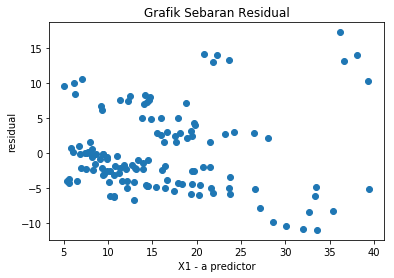

In [33]:
Y_pred = model.predict(X)
residual = y-Y_pred
plt.scatter(data_reg['persen_penduduk_miskin'],residual)
plt.xlabel("X1 - a predictor")
plt.ylabel("residual")
plt.title("Grafik Sebaran Residual")
plt.show()

In [34]:
print("p-value untuk uji-F adalah", model.f_pvalue)
print("p-value untuk uji-t adalah", stats.t.sf(model.tvalues[1], model.df_resid) * 2)
print("Nilai R-squared yang diperoleh adalah", model.rsquared)

p-value untuk uji-F adalah 4.205565481309999e-07
p-value untuk uji-t adalah 4.2055654813101607e-07
Nilai R-squared yang diperoleh adalah 0.17934380957013707


---
Selanjutnya, akan dilakukan uji F untuk menguji kelayakan model (mengetahui apakah variabel-variabel independen secara simultan berpengaruh signifikan terhadap variabel dependen).
<strong>Uji F (Uji Kecocokan Model)</strong>
<ul>
<li>Hipotesis :
    <ul>
    <li>H0 : model tidak cocok</li>
    <li>H1 : model cocok</li></ul></li>
<li>Taraf Signifikansi :</li>$\alpha = 5\%$
<li>Statistik Uji :</li>$p\text{-}value = 0.00000042$
<li>Daerah Kritis :</li>H0 ditolak jika $p\text{-}value < \alpha$
    <li>Keputusan :</li>Karena $p\text{-}value=0.00000042 < \alpha=0.05$ maka H0 ditolak
    <li>Kesimpulan :</li>
    Jadi, pada taraf signifikansi $\alpha = 0.05$ diperoleh hasil bahwa model regresi cocok.
</ul>

Selanjutnya, akan dilakukan Uji-<i>t</i> untuk menguji apakah koefisien <b>PersenMs</b> signifikan (menunjukan seberapa jauh pengaruh satu variabel independen secara individual menerangkan variasi variabel terikat).

---

<strong>Uji t</strong>
<ul>
<li>Hipotesis :
    <ul>
    <li>H0 : koefisien <b>PersenMs</b> tidak signifikan</li>
    <li>H1 : koefisien <b>PersenMs</b> signifikan</li></ul></li>
<li>Taraf Signifikansi :</li>$\alpha = 5\%$
<li>Statistik Uji :</li>$p\text{-}value = 0.00000042$
<li>Daerah Kritis :</li>H0 ditolak jika $p\text{-}value < \alpha$
    <li>Keputusan :</li>Karena $p\text{-}value=0.00000042 < \alpha=0.05$ maka H0 ditolak
    <li>Kesimpulan :</li>
    Jadi, pada taraf signifikansi $\alpha = 0.05$ diperoleh hasil bahwa koefisien <b>PersenMs</b> signifikan.
</ul>

Selanjutnya, akan dilakukan Uji Koefisien Determinasi untuk mengukur seberapa jauh kemampuan model dalam menerangkan variasi variabel dependen.

---

<strong>Uji Koefisien Determinasi</strong>

Berdasarkan output yang diperoleh di atas, didapat nilai $R^2=0.1793438$, yang artinya sebesar $17.93\%$ persentase buta huruf dipengaruhi oleh persentase kemiskinan sedangkan sisanya $82.07\%$ dipengaruhi oleh faktor lain.

---
Selanjutnya, dilakukan uji untuk asumsi-asumsi yang dikenakan. Asumsi yang pertama adalah asumsi normalitas menggunakan uji Jarque-Bera (JB). Dari tabel hasil regresi sebelumnya, diperoleh nilai probabilitas JBnya adalah 0.000954.

<strong>Asumsi Normalitas</strong>
<ul>
<li>Hipotesis :
    <ul>
    <li>H0 : residual berdistribusi normal</li>
    <li>H1 : residual tidak berdistribusi normal</li></ul></li>
<li>Taraf Signifikansi :</li>$\alpha = 5\%$
<li>Statistik Uji :</li>$p\text{-}value = 0.000954$
<li>Daerah Kritis :</li>H0 ditolak jika $p\text{-}value < \alpha$
    <li>Keputusan :</li>Karena $p\text{-}value=0.000954 < \alpha=0.05$ maka H0 ditolak
    <li>Kesimpulan :</li>
    Jadi, pada taraf signifikansi $\alpha = 0.05$ diperoleh hasil bahwa residual tidak berdistribusi normal.
</ul>

Sebetulnya, agar residual berdistribusi normal, maka perlu dilakukan transformasi Box-Cox terhadap variabel dependen dalam model regresi, yaitu <b>y</b>. Namun, dalam kasus ini diabaikan dengan memperhatikan bahwa jumlah sampel yang diobservasikan terlampau banyak. Selanjutnya, dilakukan uji untuk asumsi linearitas menggunakan Harvey-Collier multiplier test.

In [35]:
sms.linear_harvey_collier(model)

Ttest_1sampResult(statistic=-0.5123707183465908, pvalue=0.6092745649069049)

<strong>Asumsi Linearitas</strong>
<ul>
<li>Hipotesis :
    <ul>
    <li>H0 : fungsi linear</li>
    <li>H1 : fungsi tidak linear</li></ul></li>
<li>Taraf Signifikansi :</li>$\alpha = 5\%$
<li>Statistik Uji :</li>$p\text{-}value = 0.609275$
<li>Daerah Kritis :</li>H0 ditolak jika $p\text{-}value < \alpha$
    <li>Keputusan :</li>Karena $p\text{-}value=0.609275 > \alpha=0.05$ maka H0 diterima
    <li>Kesimpulan :</li>
    Jadi, pada taraf signifikansi $\alpha = 0.05$ diperoleh hasil bahwa fungsi linear.
</ul>

Selanjutnya, dilakukan uji untuk asumsi heteroskedastisitas uji Breusch-Pagan.

In [36]:
_, pval, __, f_pval = sts.diagnostic.het_breuschpagan(residual, data_reg[['persen_penduduk_miskin', 'persentase_buta_huruf']])
pval, f_pval

(2.3172196976134077e-19, 1.5256605869880685e-27)

<strong>Asumsi Heteroskedastisitas</strong>
<ul>
<li>Hipotesis :
    <ul>
    <li>H0 : varian residual homogen</li>
    <li>H1 : varian residual tidak homogen</li></ul></li>
<li>Taraf Signifikansi :</li>$\alpha = 5\%$
<li>Statistik Uji :</li>$p\text{-}value = 0.000$
<li>Daerah Kritis :</li>H0 ditolak jika $p\text{-}value < \alpha$
    <li>Keputusan :</li>Karena $p\text{-}value=0.000 < \alpha=0.05$ maka H0 ditolak
    <li>Kesimpulan :</li>
    Jadi, pada taraf signifikansi $\alpha = 0.05$ diperoleh hasil bahwa varian residual tidak homogen (terjadi heteroskedastisitas).
</ul>

Terakhir, dilakukan uji untuk asumsi autokorelasi.

In [37]:
_, pval, __, f_pval = sts.diagnostic.acorr_breusch_godfrey(model)
pval, f_pval

(2.952325437334408e-13, 9.3855029584019e-22)

<strong>Asumsi Autokorelasi</strong>

<strong>1. Durbin-Watson (d) Test</strong>

Dari tabel hasil regresi sebelumnya, diperoleh nilai $d=0.471$. Karena nilai $d$ tidak mendekati 2 maka terjadi autokorelasi positif.

<strong>2. Breusch-Godfrey (BG) Test</strong>
<ul>
<li>Hipotesis :
    <ul>
    <li>H0 : tidak terjadi autokorelasi</li>
    <li>H1 : terjadi autokorelasi</li></ul></li>
<li>Taraf Signifikansi :</li>$\alpha = 5\%$
<li>Statistik Uji :</li>$p\text{-}value = 0.000$
<li>Daerah Kritis :</li>H0 ditolak jika $p\text{-}value < \alpha$
    <li>Keputusan :</li>Karena $p\text{-}value=0.0.000 < \alpha=0.05$ maka H0 ditolak
    <li>Kesimpulan :</li>
    Jadi, pada taraf signifikansi $\alpha = 0.05$ diperoleh hasil bahwa variabel terjadi autokorelasi.
</ul>

##### Analisis :

Model regresi menunjukkan ada korelasi positif dari kedua aspek tersebut. Artinya, rasa penasaran penulis terjawab. Bahwa semakin parah kemiskinan di suatu daerah, secara tidak langsung berdampak pada tingkat persentase buta hurufnya. Meski demikian, diperoleh di analisis regresi di atas, bahwa ada lebih dari 90% faktor lain yang mempengaruhi tingkat buta huruf selain kemiskinan. Analisis ini dapat dikembangkan lebih lanjut melalui analisis regresi linear berganda atau analisis lainnya yang lebih "canggih".

Selain itu, diperoleh bahwa variabel memungkinkan terjadi autokorelasi, yaitu adanya korelasi antara serial data atau antara data sebelum dengan data sesudahnya dalam data yang disusun berdasarkan urutan waktu (time series). Artinya, ada pengaruh waktu terhadap perubahan variabel di model regresi. Selain itu, model regresi juga terjadi heteroskedastisitas yang mengakibatkan tingkat konfidensi model semakin sempit. Dengan kata lain, model regresi bisa cenderung tidak valid untuk peramalan. Barangkali hal ini wajar karena memang kemiskinan bukanlah faktor utama yang menentukan tingkat kebutaan huruf dari suatu daerah.